## Plotting Words per Line over Narrative Space in Virgil's *Aeneid*

This notebook explain how to measure a formal feature in a text and then plot that feature over narrative space, using word count per line of Virgil's *Aeneid* as an example. This is pretty straightforward actually. All we need to do is tokenize the text of each book by line, tokenize each line by word, and then count the words. We make this list of wordcounts our *y* axis and the line numbers themselves the *x* axis.

The result is a pretty jagged lineplot since the counts are more or less arbitrarily determined, so I also show here how to smooth this plot by getting the running average over certain number of line, i.e. a window. I'm not sure we learn much from this particular experiment—word length is steadily between 6 and 7 words throughout the poem. But if we were measuring something more meaningful, i.e. less arbitrary within a window (like I do in [this paper](https://jdmdh.episciences.org/3821/pdf) with the density of elegiac intertexts in Lucan's *Bellum civile*), the smoothed graph can be a good indicator of a feature trend in narrative space.

One interesting side note here, a Classics Python 'recipe', if you will: I use the CLTK Latin Library corpus for this experiment and the files are not strictly in 'book' order. That is, because of alphanumeric sorting, we get the sequence ```['vergil/aen1.txt', 'vergil/aen10.txt', 'vergil/aen11.txt', 'vergil/aen12.txt', 'vergil/aen2.txt', etc.]```. Below I show a method for deriving the 'book' sort order that may come in hand in other experiments. [PJB 3.21.18]


In [1]:
# Import

import re

from cltk.tokenize.line import LineTokenizer
from cltk.tokenize.word import WordTokenizer
from cltk.corpus.latin import latinlibrary

import matplotlib.pyplot as plt
%matplotlib inline  

from pprint import pprint

In [2]:
# Set up tokenizers

line_tokenizer = LineTokenizer('latin')
word_tokenizer = WordTokenizer('latin')

In [3]:
# Get files
aeneid = [file for file in latinlibrary.fileids() if '/aen' in file]
print(aeneid)

['vergil/aen1.txt', 'vergil/aen10.txt', 'vergil/aen11.txt', 'vergil/aen12.txt', 'vergil/aen2.txt', 'vergil/aen3.txt', 'vergil/aen4.txt', 'vergil/aen5.txt', 'vergil/aen6.txt', 'vergil/aen7.txt', 'vergil/aen8.txt', 'vergil/aen9.txt']


In [4]:
# Put files in 'correct' order

aeneid_order = [int(" ".join(re.findall(r'\d+', item))) for item in aeneid]
aeneid = [x for _, x in sorted(zip(aeneid_order, aeneid))]
print(aeneid)

['vergil/aen1.txt', 'vergil/aen2.txt', 'vergil/aen3.txt', 'vergil/aen4.txt', 'vergil/aen5.txt', 'vergil/aen6.txt', 'vergil/aen7.txt', 'vergil/aen8.txt', 'vergil/aen9.txt', 'vergil/aen10.txt', 'vergil/aen11.txt', 'vergil/aen12.txt']


In [5]:
# Make well-formatted titles for plot

aeneid_titles = ['Aeneid {}'.format(re.search(r'\d+', item).group()) for item in aeneid]
print(aeneid_titles)

['Aeneid 1', 'Aeneid 2', 'Aeneid 3', 'Aeneid 4', 'Aeneid 5', 'Aeneid 6', 'Aeneid 7', 'Aeneid 8', 'Aeneid 9', 'Aeneid 10', 'Aeneid 11', 'Aeneid 12']


In [6]:
# Get raw text of Latin Library files

aeneid_raw = [latinlibrary.raw(file) for file in aeneid]

In [7]:
# Script for preprocessing texts

import html
import string
from cltk.stem.latin.j_v import JVReplacer

def preprocess(text):
    
    replacer = JVReplacer()
    
    remove_list = [r'\bThe Latin Library\b',
                   r'\bThe Classics Page',
                   r'\bVergil: Aeneid .+\b',
                   r'\bP. VERGILI MARONIS AENEIDOS LIBER .+\b',
                   r'\bVergil\b'
                  ]
    
    for pattern in remove_list:
        text = re.sub(pattern, '', text)
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
        
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j    
    
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
    
    return text.strip()

In [8]:
# Preprocess texts
aeneid_preprocess = [preprocess(raw) for raw in aeneid_raw]

In [9]:
# Tokenize texts by line

aeneid_lines = [line_tokenizer.tokenize(text) for text in aeneid_preprocess]

In [10]:
# Get linecounts per book

aeneid_book_linecounts = [len(lines) for lines in aeneid_lines]
print('Book 1 has {} lines.'.format(aeneid_book_linecounts[0]))

Book 1 has 756 lines.


In [11]:
# Get word count per line per book

aeneid_wpl = [[len(line.split()) for line in lines] for lines in aeneid_lines]
pprint(aeneid_wpl[0][:10])

[8, 5, 8, 7, 8, 6, 6, 7, 7, 6]


In [12]:
# Get max values for x and y axes on plot

# ylim ~ max count in list of lists
ylim = max(max(item) for item in aeneid_wpl)

# xlim ~ max count of book length by lines
xlim = max(aeneid_book_linecounts)

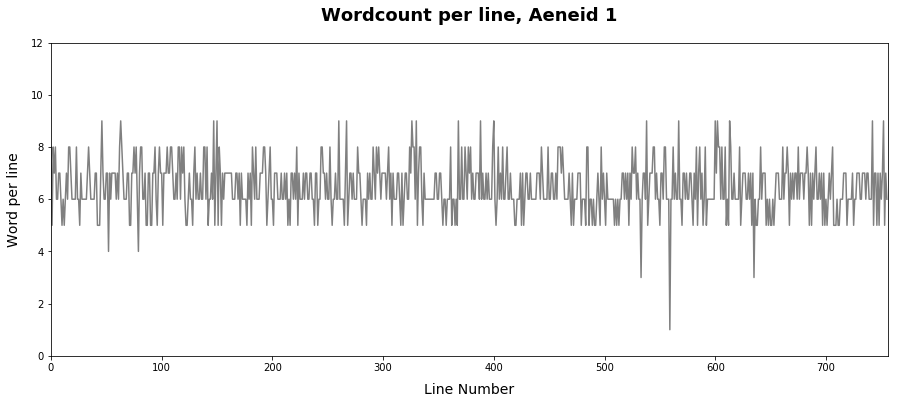

In [13]:
# Plot word count per line for Aeneid 1

xs = range(0,len(aeneid_wpl[0]))
ys = aeneid_wpl[0]

fig = plt.figure()
fig.set_size_inches(15,6)
ax = fig.add_subplot(111)

ax.plot(xs, ys, color='.5')

t =  plt.title('Wordcount per line, Aeneid 1',fontsize = 18, fontweight = "bold")
t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.xaxis.labelpad = 10 
ax.yaxis.labelpad = 10 

ax.set_xlim(0, len(xs))
ax.set_ylim(0, ylim+1)

ax.set_xlabel('Line Number', fontsize = 14)
ax.set_ylabel('Word per line', fontsize = 14)
plt.show()

In [14]:
# Analyze 'outlier'

low_count = min(aeneid_wpl[0])
low_count_line = aeneid_wpl[0].index(1)

print('The minimum length of {} can be found at line 1.{}\n'.format(low_count, low_count_line+1))
print('Here is the line in context:')
print('\n'.join(aeneid_lines[0][low_count_line-5:low_count_line+6]))

The minimum length of 1 can be found at line 1.560

Here is the line in context:
sin absumpta salus et te pater optime teucrum 
pontus habet libyae nec spes iam restat iuli 
at freta sicaniae saltem sedesque paratas 
unde huc aduecti regemque petamus acesten
talibus ilioneus cuncti simul ore fremebant 
dardanidae
tum breuiter dido uoltum demissa profatur
soluite corde metum teucri secludite curas 
res dura et regni nouitas me talia cogunt 
moliri et late finis custode tueri 
quis genus aeneadum quis troiae nesciat urbem 


In [15]:
# Function for smoothing line plot with moving average

def smooth_list(x, window):
    smoothed_list = []
    for i in range(0,len(x)-window):
        smoothed_list.append(sum(x[i:i+window])/window)
    return smoothed_list

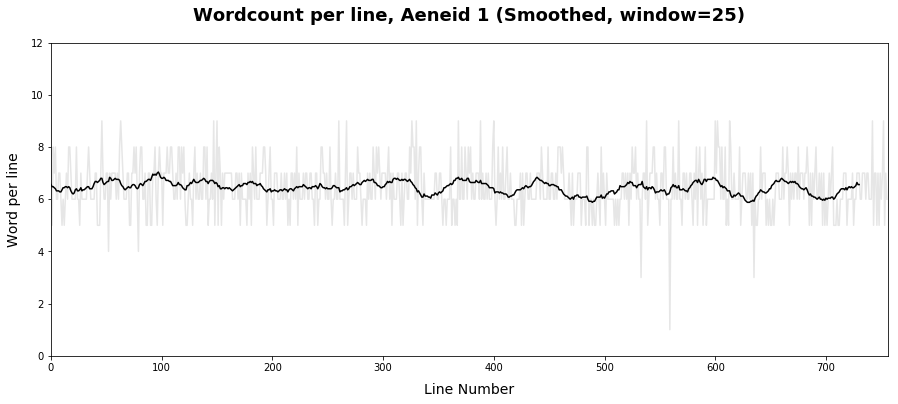

In [16]:
# Plot word count per line for Aeneid 1 with moving average

xs = range(0,len(aeneid_wpl[0]))
ys = aeneid_wpl[0]

ys_smooth = smooth_list(ys, 25)
xs_smooth = range(0,len(ys_smooth))

fig = plt.figure()
fig.set_size_inches(15,6)
ax = fig.add_subplot(111)

ax.plot(xs, ys, color='0.90')
ax.plot(xs_smooth, ys_smooth, color='0')

t =  plt.title('Wordcount per line, Aeneid 1 (Smoothed, window=25)',fontsize = 18, fontweight = "bold")
t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.xaxis.labelpad = 10 
ax.yaxis.labelpad = 10 

ax.set_xlim(0, len(xs))
ax.set_ylim(0, ylim+1)

ax.set_xlabel('Line Number', fontsize = 14)
ax.set_ylabel('Word per line', fontsize = 14)
plt.show()

In [17]:
# Generalize the plot to a function

def plot_word_counts(wpl, title, ylim, xlim, window=25):
    ys = wpl
    xs = range(0,len(wpl))
    ys_smooth = smooth_list(ys, window)
    xs_smooth = range(0,len(ys_smooth))
    
    fig = plt.figure()
    fig.set_size_inches(15,6)
    ax = fig.add_subplot(111)

    ax.plot(xs, ys, color='0.90')
    ax.plot(xs_smooth, ys_smooth, color='0')

    t =  plt.title('Wordcount per line, {} (Smoothed, window={})'.format(title, window),fontsize = 18, fontweight = "bold")
    t.set_y(1.05)
    fig.subplots_adjust(top=0.85)

    ax.xaxis.labelpad = 10 
    ax.yaxis.labelpad = 10 

    ax.set_xlim(0, xlim)
    ax.set_ylim(0, ylim+1)

    ax.set_xlabel('Line Number', fontsize = 14)
    ax.set_ylabel('Word per line', fontsize = 14)
    plt.show()
    

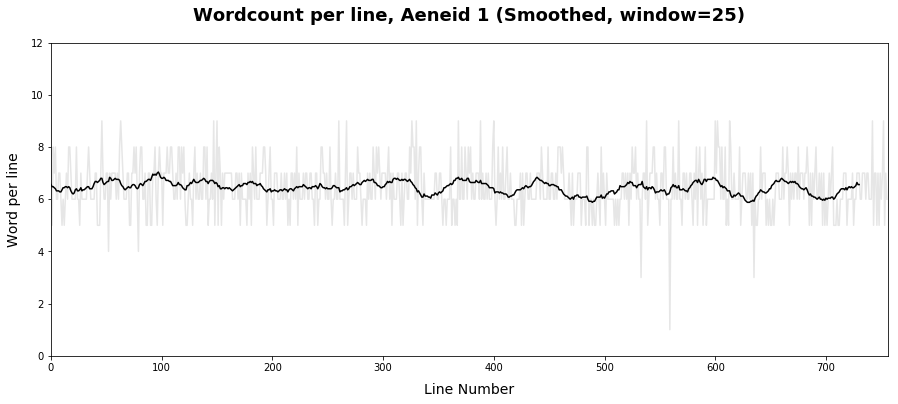

In [18]:
# Same plot as above, but from function

plot_word_counts(aeneid_wpl[0], aeneid_titles[0], ylim=ylim, xlim=aeneid_book_linecounts[0])

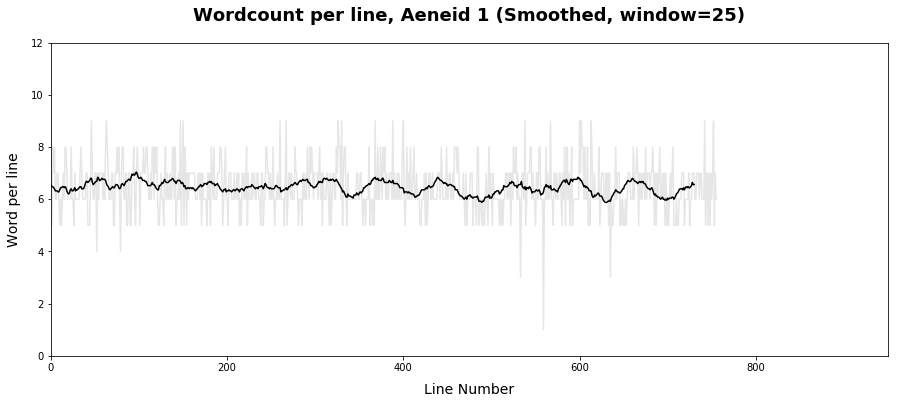

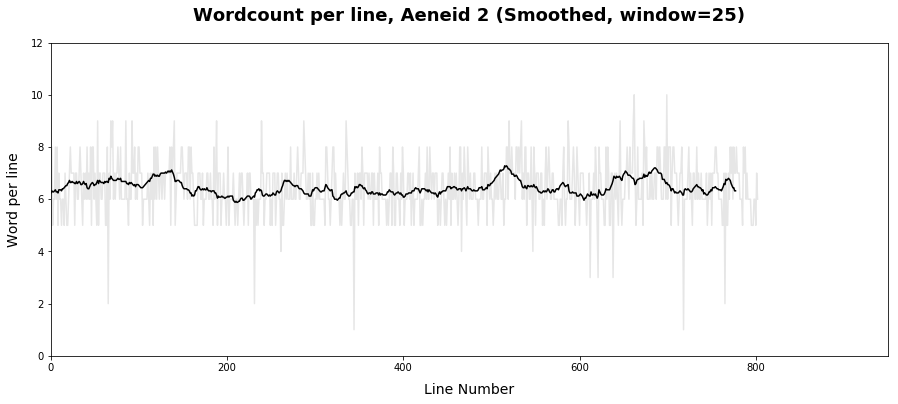

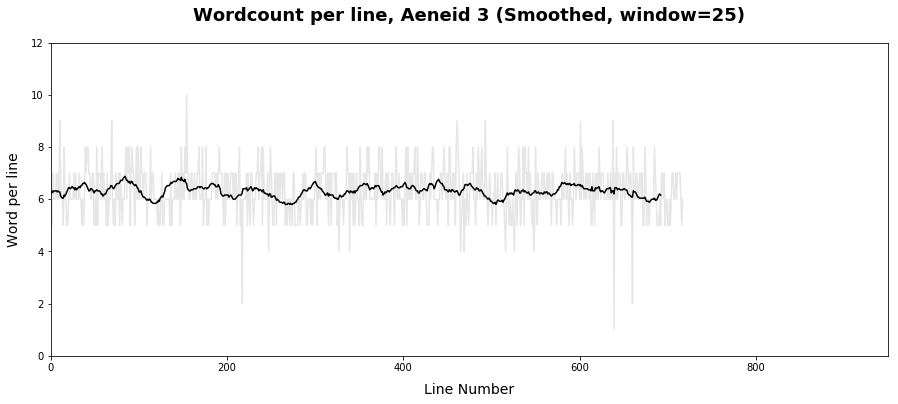

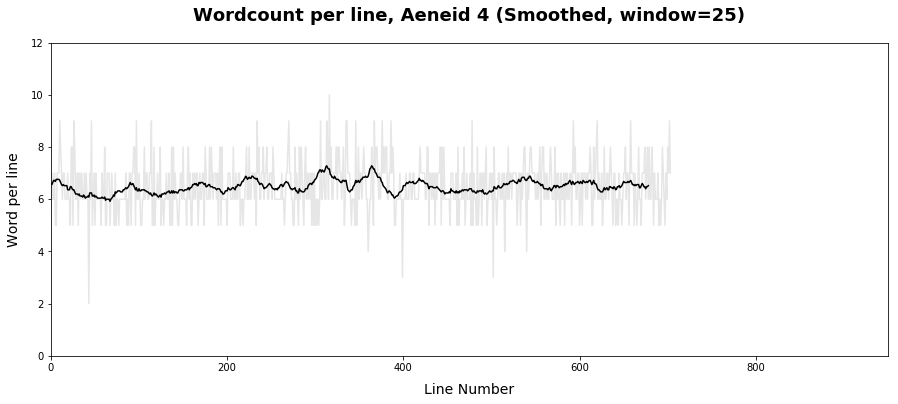

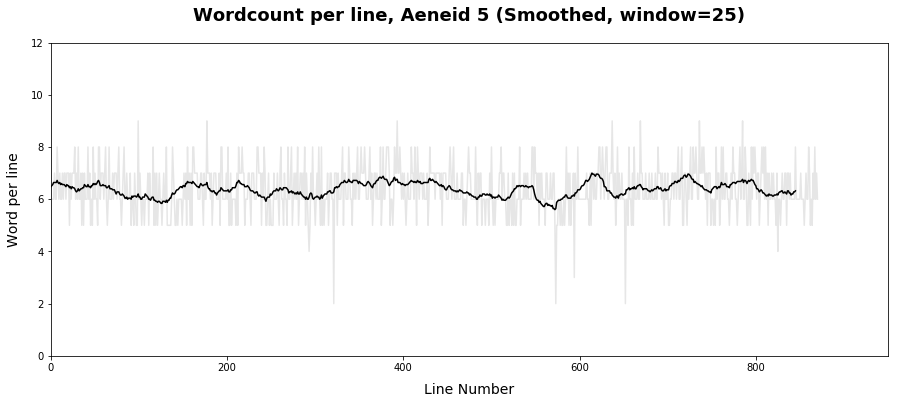

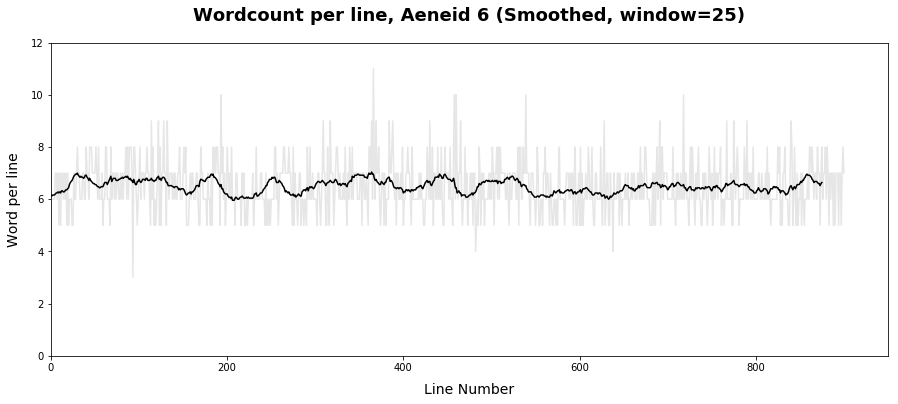

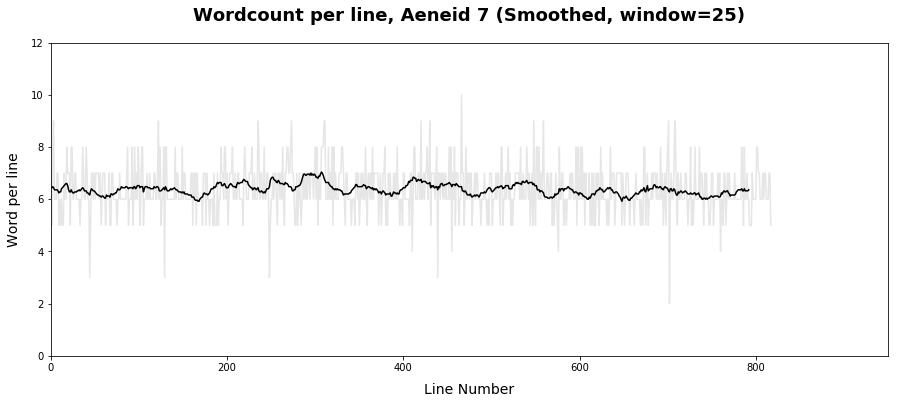

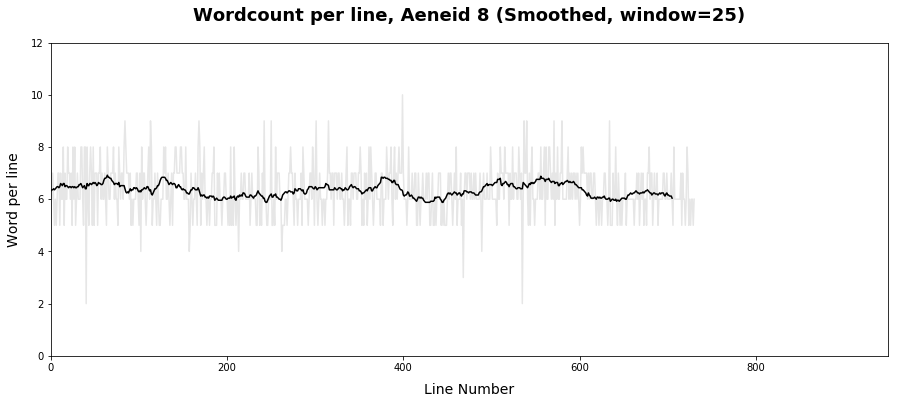

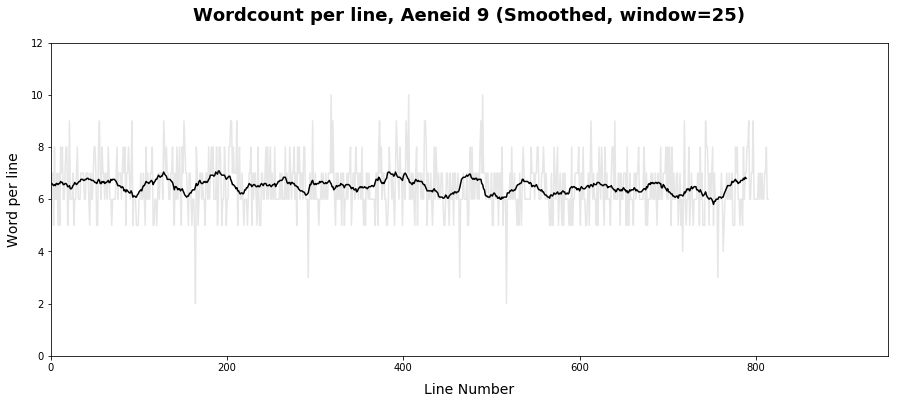

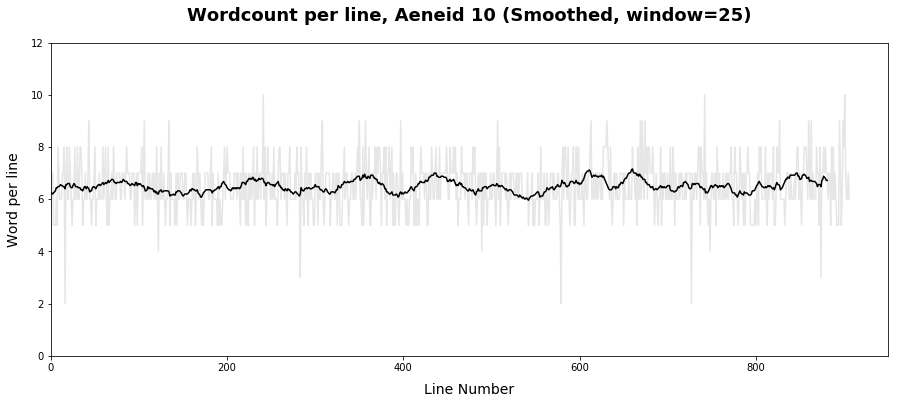

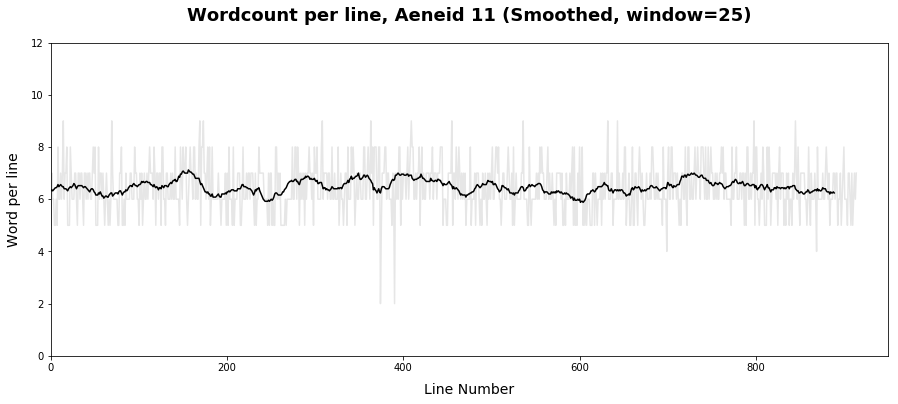

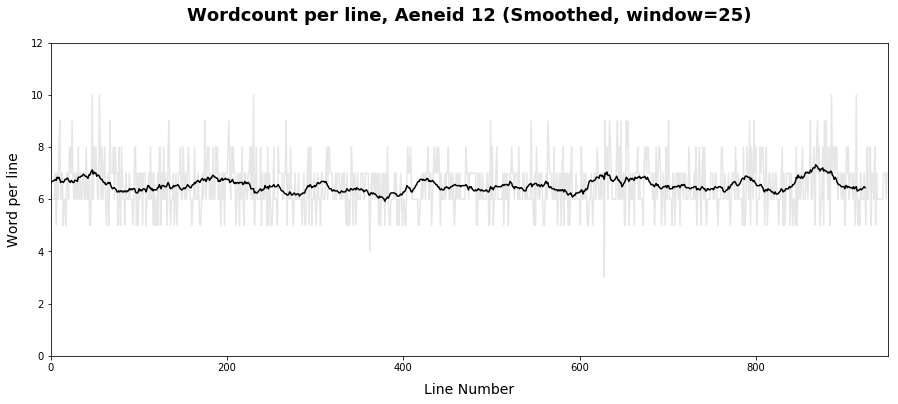

In [19]:
# With plot as function, we can iterate over the list of titles, etc. and generate plots
# for all 12 books of the Aeneid

for i, title in enumerate(aeneid_titles):
    plot_word_counts(aeneid_wpl[i], title, ylim=ylim, xlim=xlim)